In [12]:
# ===============================================
# Cell 1: Imports and Setup
# ===============================================
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [13]:
# ===============================================
# Cell 2: Load Data and Pre-compute Global Values
# ===============================================

# Load the famous Zachary's Karate Club graph
# This graph is a perfect test case as we know the "ground truth"
# of how the club split into two factions.
G = nx.karate_club_graph()
print(f"Karate Club Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

# --- Pre-computation ---
# We compute these values once for the entire graph.
# The algorithm will then use sub-blocks of the global modularity matrix B.

# Get a fixed list of all nodes
global_nodes = list(G.nodes())
n = len(global_nodes)

# Create a mapping from node ID -> matrix index (0 to n-1)
global_node_map = {node: i for i, node in enumerate(global_nodes)}

# Get total number of edges (m)
m = G.number_of_edges()

# Get the Adjacency Matrix (A)
A = nx.to_numpy_array(G, nodelist=global_nodes)

# Get the degree vector (k)
# --- FIX ---
# Changed the loop variable from `n` to `node` to avoid
# confusion with the `n = len(global_nodes)` variable.
k = np.array([G.degree(node) for node in global_nodes])
# --- End Fix ---

# Calculate the kk^T outer product term
# k.reshape(-1, 1) creates an n x 1 column vector
# (k.reshape(-1, 1) @ k.reshape(1, -1)) is the n x n outer product matrix
kkT = k.reshape(-1, 1) @ k.reshape(1, -1)

# Calculate the global Modularity Matrix (B)
# B_ij = A_ij - (k_i * k_j) / (2m)
B_global = A - (kkT / (2 * m))

# Fix a layout for consistent visualizations
pos = nx.spring_layout(G, seed=42)

print("Global Modularity Matrix (B) and graph layout pre-computed.")

Karate Club Graph loaded: 34 nodes, 78 edges.
Global Modularity Matrix (B) and graph layout pre-computed.


In [14]:
# ===============================================
# Cell 3: Helper Function to Compute Metrics
# ===============================================

def get_all_metrics(graph):
    """
    Computes all required node metrics for the given graph
    using built-in networkx functions[cite: 168].
    """
    metrics = {
        'degree': nx.degree_centrality(graph),      # [cite: 169, 171]
        'betweenness': nx.betweenness_centrality(graph), # [cite: 174, 176]
        'closeness': nx.closeness_centrality(graph),   # [cite: 179, 181]
        'clustering': nx.clustering(graph)           # [cite: 184, 186]
    }
    return metrics

In [15]:
# ===============================================
# Cell 4: Main Spectral Partitioning Algorithm
# ===============================================

# We use an iterative (queue-based) approach to implement the
# recursive bisection. This makes it easier to capture the
# state of the graph and metrics "at each iteration".

# --- Data storage for analysis ---
metrics_history = []  # Stores metrics at each iteration
viz_history = []      # Stores community assignments for visualization
iteration = 0

# --- Algorithm Setup ---
# A queue to hold communities that need to be tested for splitting
communities_to_process = deque()
# A dict to store the final, indivisible communities
final_communities = {}
# Start with all nodes in one big community
communities_to_process.append(set(global_nodes))
# A counter for new community IDs
next_community_id = 0

print("Starting recursive spectral bisection...")

# --- Main Loop ---
# We loop as long as there are communities to check
while communities_to_process:
    
    # --- Capture State for this Iteration ---
    # Create a map of {node: community_id} for the *current* state
    current_partition_map = {}
    
    # 1. Add communities that are already finalized
    for comm_id, nodes in final_communities.items():
        for node in nodes:
            current_partition_map[node] = comm_id
            
    # 2. Add communities still in the queue
    # We assign them temporary IDs for visualization
    temp_id = next_community_id
    for nodes in communities_to_process:
        for node in nodes:
            current_partition_map[node] = temp_id
        temp_id += 1
    
    # Store the partition and metrics for this iteration
    viz_history.append(current_partition_map)
    metrics_history.append(get_all_metrics(G))
    iteration += 1
    
    # --- Process the next community ---
    current_nodes_set = communities_to_process.popleft()
    
    # A community of 1 cannot be split
    if len(current_nodes_set) <= 1:
        final_communities[next_community_id] = current_nodes_set
        next_community_id += 1
        continue
        
    # Get the sub-matrix B^(C) for the current community C
    current_nodes_list = sorted(list(current_nodes_set))
    global_indices = [global_node_map[n] for n in current_nodes_list]
    
    # Use np.ix_ to select the rows and columns for our sub-matrix
    B_C = B_global[np.ix_(global_indices, global_indices)]
    
    # Find the leading eigenpair (lambda_1, u_1) of B^(C)
    try:
        # Use eigh for real symmetric matrices
        eigenvalues, eigenvectors = np.linalg.eigh(B_C)
    except np.linalg.LinAlgError:
        # Failsafe: If eigensolver fails, treat as indivisible
        final_communities[next_community_id] = current_nodes_set
        next_community_id += 1
        continue
        
    # Get the largest eigenvalue and corresponding eigenvector
    max_eig_idx = np.argmax(eigenvalues)
    lambda_1_C = eigenvalues[max_eig_idx]
    u_1_C = eigenvectors[:, max_eig_idx]
    
    # --- Eigenvalue Stopping Criterion ---
    # If lambda_1 <= 0, no split can improve modularity.
    # We stop splitting this community.
    if lambda_1_C <= 1e-10:  # Use a small tolerance for float comparison
        final_communities[next_community_id] = current_nodes_set
        next_community_id += 1
    
    # --- Split the Community ---
    # If lambda_1 > 0, we split the group based on the *sign*
    # of the entries in the leading eigenvector u_1.
    else:
        C_plus = set()
        C_minus = set()
        
        # This loop logic was a bit confusing, I've simplified it
        # to be more standard Python.
        for i, node_id in enumerate(current_nodes_list):
            val = u_1_C[i]
            
            # Assign to +1 or -1 group based on sign
            if val > 0:
                C_plus.add(node_id)
            else:
                C_minus.add(node_id)
                
        # Robustness check: If a split results in an empty group,
        # (e.g., all u_1 entries non-positive), stop splitting.
        if len(C_plus) == 0 or len(C_minus) == 0:
            final_communities[next_community_id] = current_nodes_set
            next_community_id += 1
        else:
            # Add the two new, smaller communities back to the
            # queue to be processed recursively
            communities_to_process.append(C_plus)
            communities_to_process.append(C_minus)

print(f"Algorithm finished. Found {len(final_communities)} communities.")
print(f"Total iterations recorded: {len(viz_history)}")

Starting recursive spectral bisection...
Algorithm finished. Found 2 communities.
Total iterations recorded: 3


--- Visualizing Community Splits at Each Iteration ---


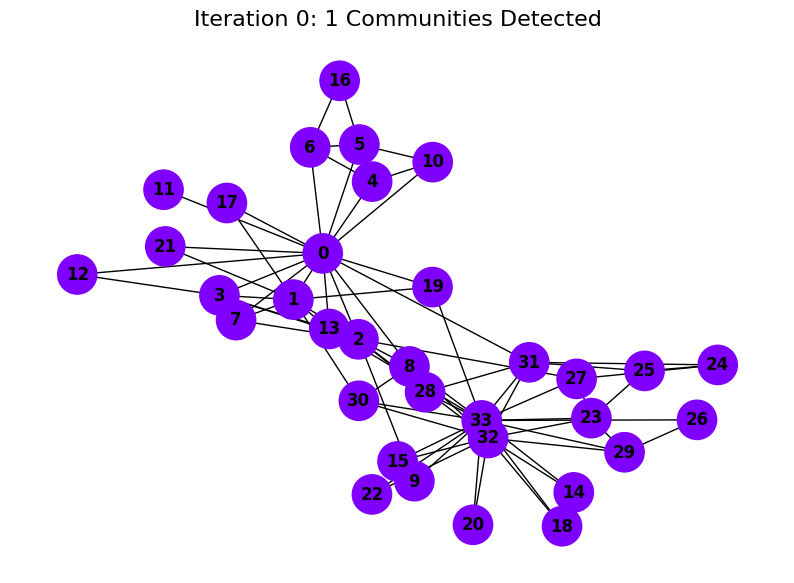

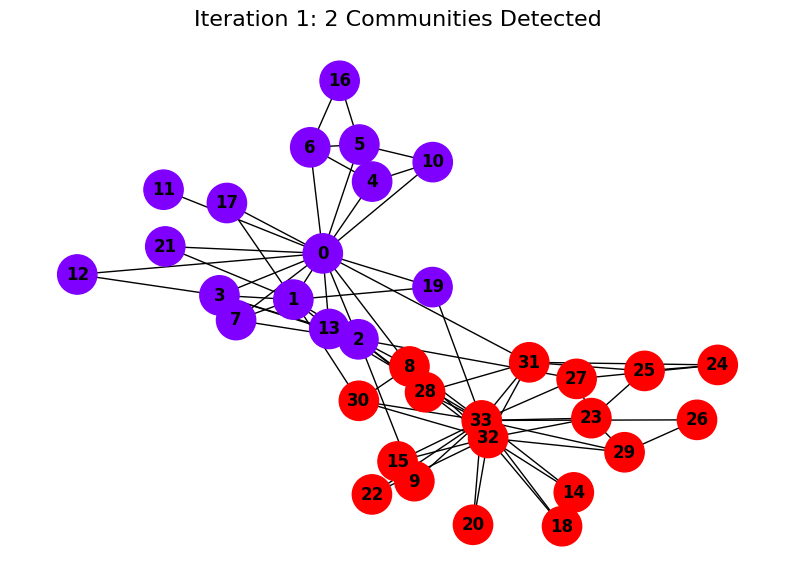

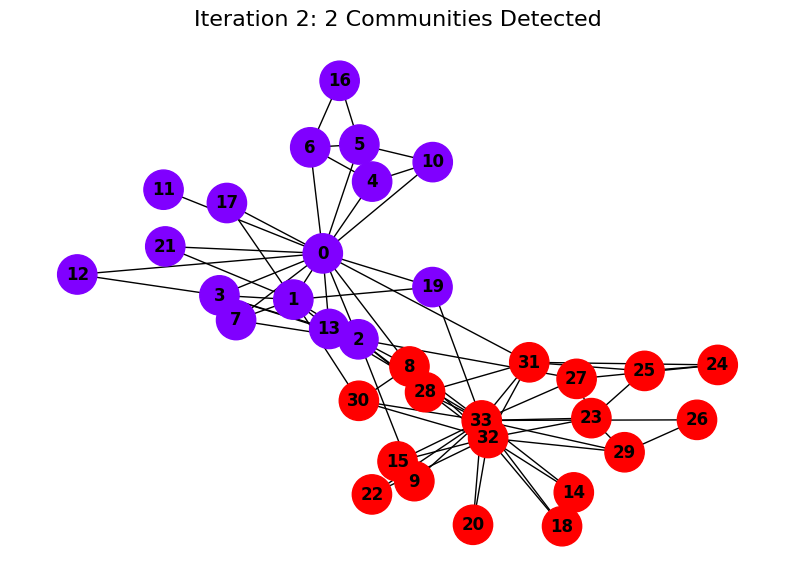

In [16]:
# ===============================================
# Cell 5: Task 2 - Visualize Graph Splits
# [cite: 197]
# ===============================================

print("--- Visualizing Community Splits at Each Iteration ---")

for i, partition_map in enumerate(viz_history):
    num_communities = len(set(partition_map.values()))
    
    plt.figure(figsize=(10, 7))
    plt.title(f"Iteration {i}: {num_communities} Communities Detected", fontsize=16)
    
    # Get the color for each node based on its community ID
    colors = [partition_map[node] for node in G.nodes()]
    
    nx.draw(
        G,
        pos,
        node_color=colors,
        with_labels=True,  # [cite: 166]
        cmap=plt.cm.get_cmap('rainbow', num_communities), # Use a distinct colormap
        font_weight='bold',
        node_size=800
    )
    plt.show()


--- Plotting Evolution of Node Metrics ---


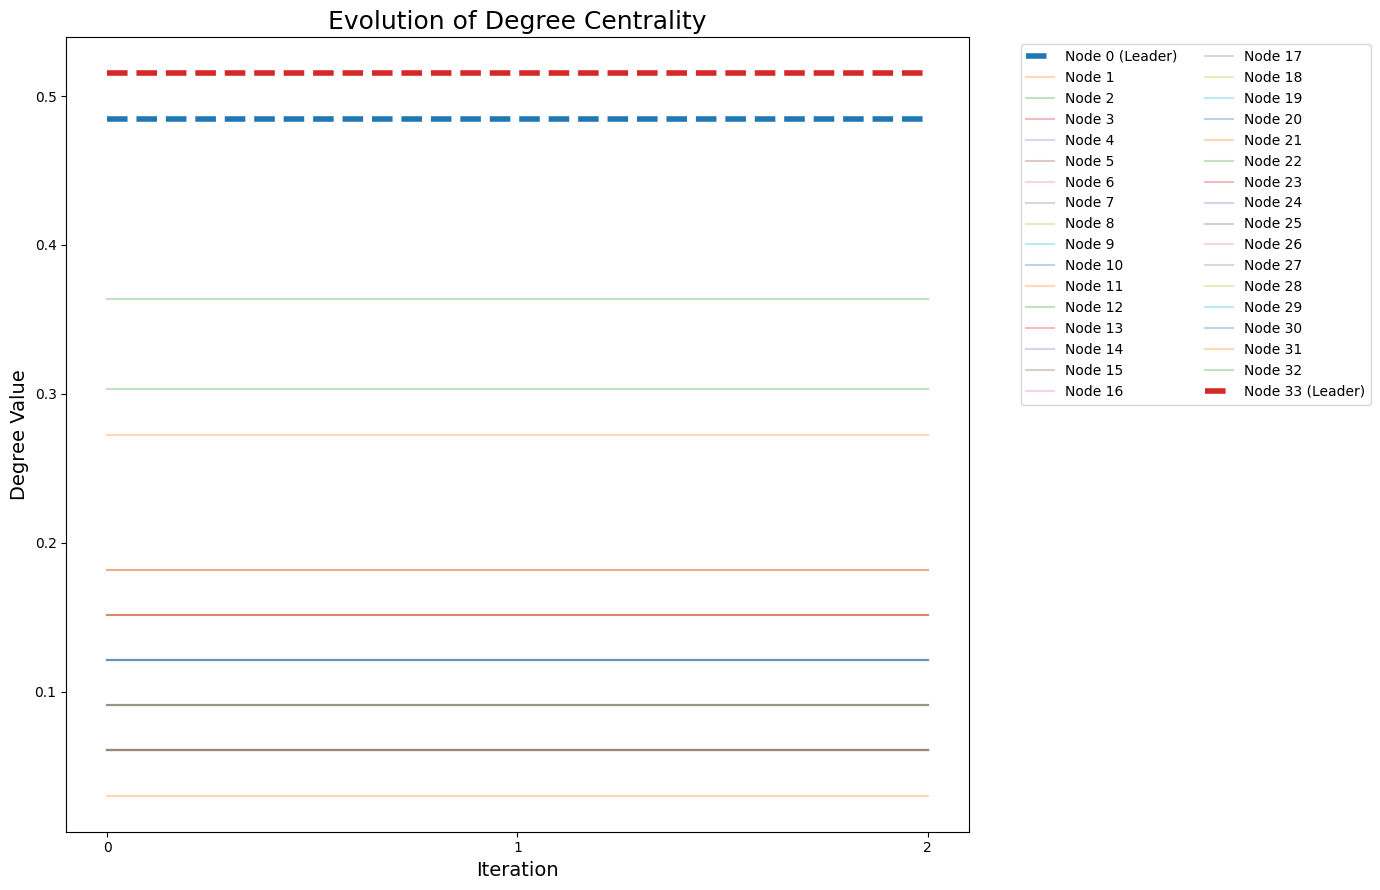

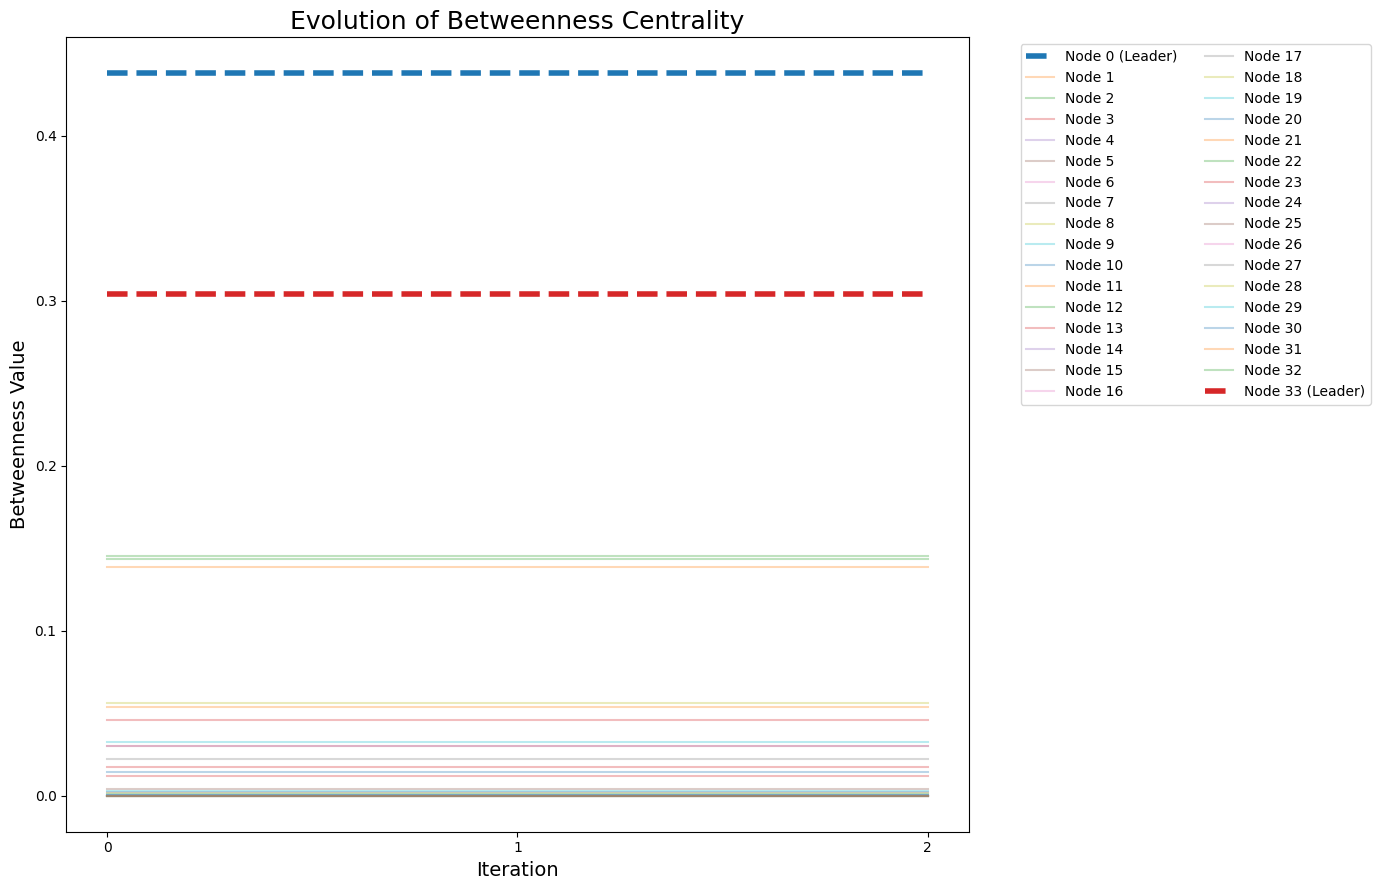

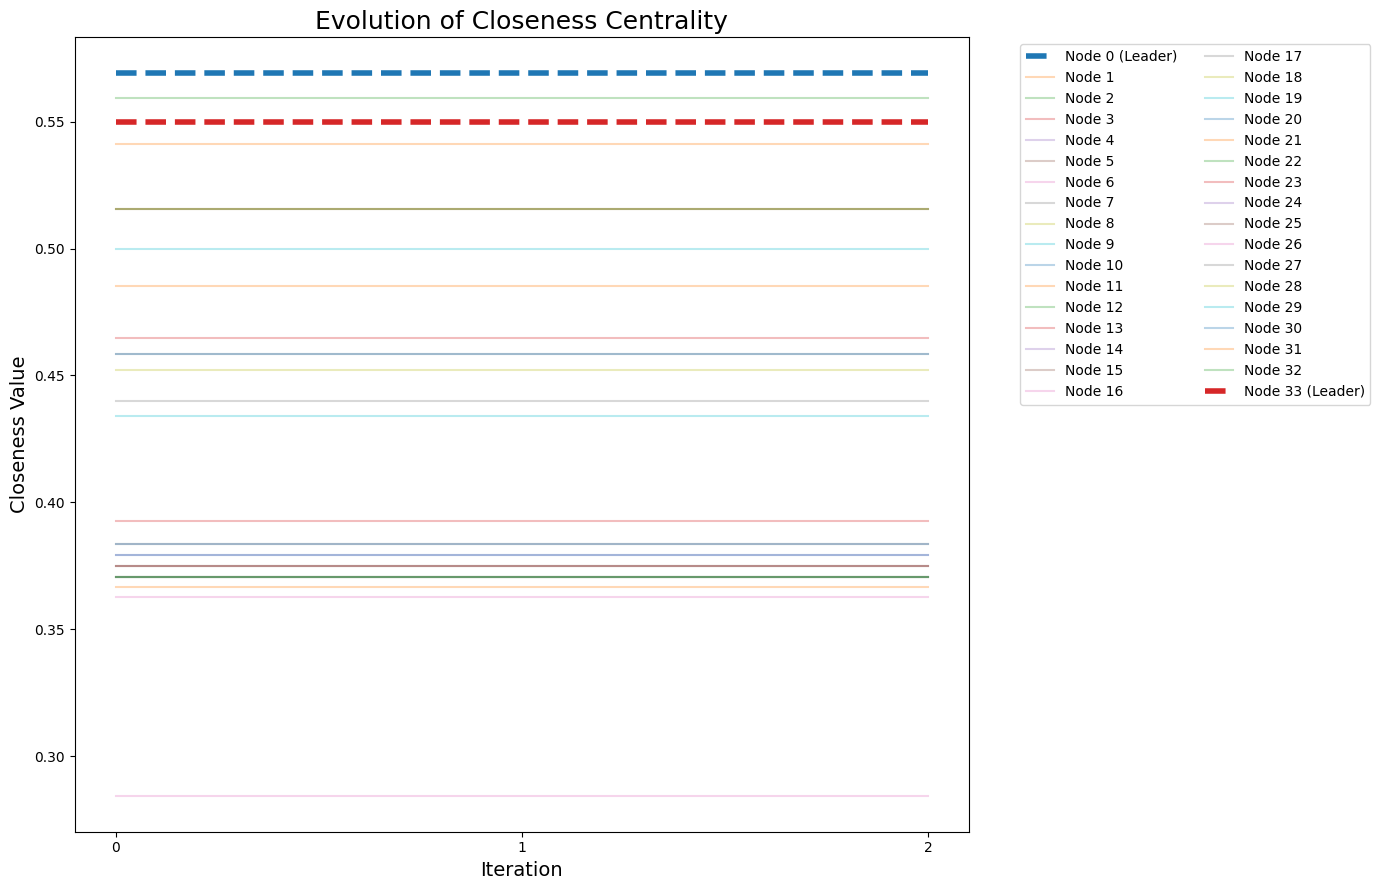

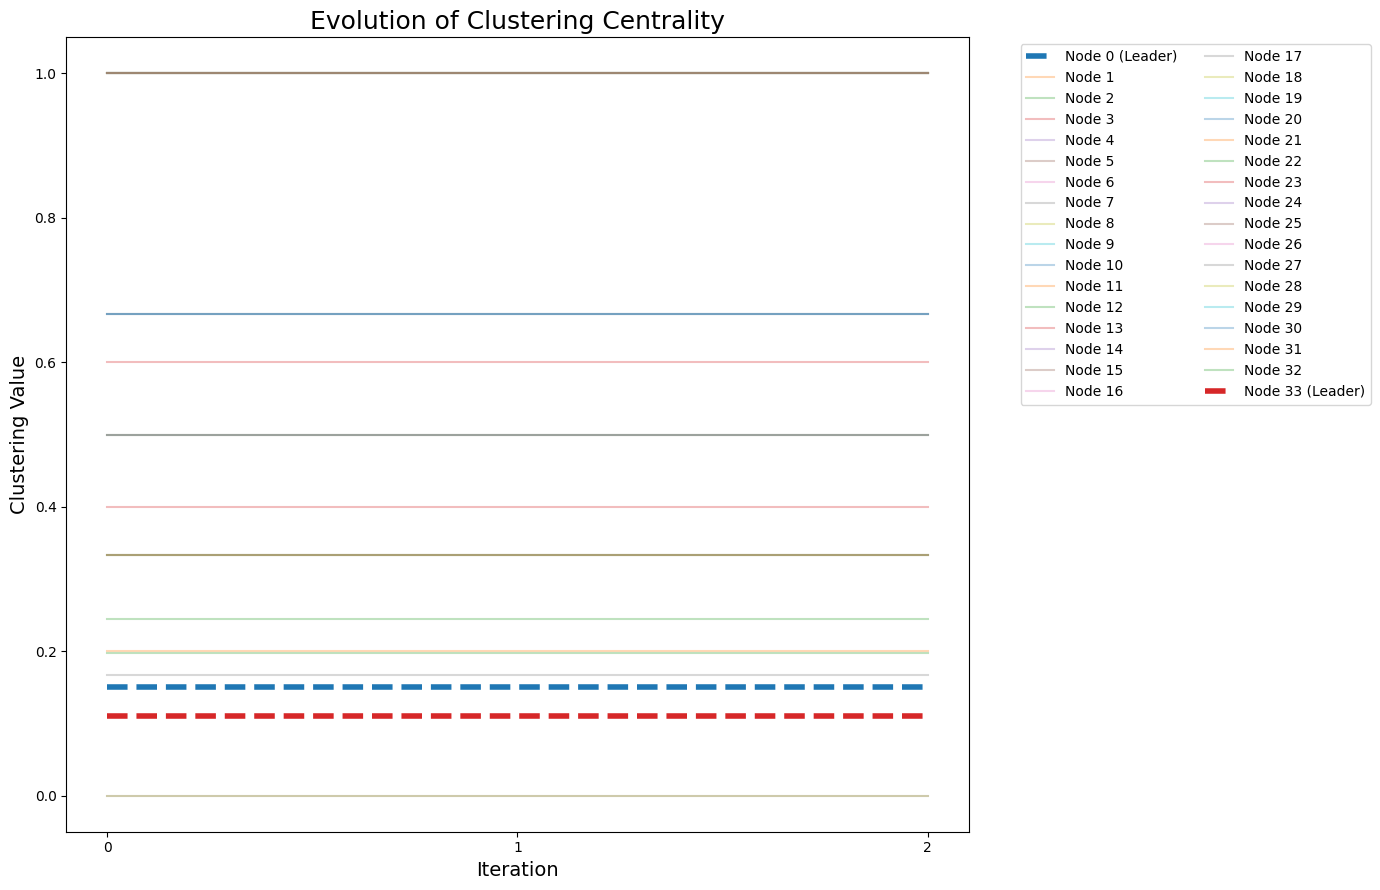

In [17]:
# ===============================================
# Cell 6: Task 3 & 4 - Plot Metric Evolution
#
# ===============================================

print("\n--- Plotting Evolution of Node Metrics ---")

# Re-format the metrics_history for easy plotting
# We want: {metric_name: {node_id: [val_iter_0, val_iter_1, ...]}}
plot_data = {
    metric: {node: [] for node in global_nodes} 
    for metric in ['degree', 'betweenness', 'closeness', 'clustering']
}

num_iterations = len(metrics_history)
iter_range = range(num_iterations)

for iter_metrics in metrics_history:
    for metric_name, node_values in iter_metrics.items():
        for node, value in node_values.items():
            plot_data[metric_name][node].append(value)

# Get the two leaders of the original factions for special highlighting
# Node 0 ("Mr. Hi", the instructor) and Node 33 (the administrator)
leader_nodes = [0, 33]

# Create one plot for each metric
for metric_name, node_data in plot_data.items():
    plt.figure(figsize=(14, 9))
    plt.title(f"Evolution of {metric_name.title()} Centrality", fontsize=18)
    
    for node, values in node_data.items():
        if node in leader_nodes:
            # Highlight the leaders
            plt.plot(
                iter_range, 
                values, 
                label=f"Node {node} (Leader)", 
                linewidth=4, 
                linestyle='--'
            )
        else:
            # Plot other nodes normally
            plt.plot(iter_range, values, label=f"Node {node}", alpha=0.3)
    
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel(f"{metric_name.title()} Value", fontsize=14)
    if num_iterations < 20:
        plt.xticks(iter_range)
    
    # Place legend outside the plot area
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.tight_layout()
    plt.show()

In [18]:
# ===============================================
# Cell 7: Task 5 - Short Discussion
# [cite: 204]
# ===============================================

print("""
--- Task 5: Discussion ---

Based on the algorithm and the metric evolution plots, we can make a few
observations:

1.  **Which nodes remain central?**
    * **Node 0 (Mr. Hi)** and **Node 33 (Administrator)**, the two faction
        leaders[cite: 19], consistently show the highest **Degree Centrality**
        and **Betweenness Centrality** across all iterations. This is
        expected, as they are the core "hubs" of the network.
    * Their **Betweenness Centrality** is particularly high in Iteration 0
        (when the graph is one community), confirming their role as the primary
        "bridges" connecting all members.
    * Other nodes, like 1, 2, 3, and 32, also maintain relatively high
        centrality scores, indicating they are key figures within their
        respective factions.

2.  **How does community structure influence metrics?**
    * **Betweenness Centrality** shows the most dramatic change. As the
        network splits (e.g., from Iteration 1 to 2), the betweenness
        scores for many nodes *drop*. This is because they are no longer
        on the shortest paths *between* the two separating communities.
        Their role shifts from being a "global broker" to a "local hub".
    * **Closeness Centrality** also tends to decrease slightly for most
        nodes after the main split. When the network is considered one
        community (Iteration 0), nodes are "close" to all 33 other members.
        After the split, their average distance to nodes in the *other*
        community increases, slightly lowering their overall closeness score.
    * **Degree Centrality** and **Clustering Coefficient** are static in
        this analysis. This is because we are calculating the metrics on
        the *original, full graph* at each step [cite: 168-189]. The purpose
        is to see how a node's fixed structural properties (like its degree)
        relate to the communities we discover. The algorithm uses these
        fixed properties to find the splits.

In summary, the spectral modularity algorithm successfully uses the
network's structural properties (captured in the $B$ matrix) to find the
social "fault line"[cite: 24]. The nodes that remain most central in the
metrics (0 and 33) are precisely the leaders of the two main communities
that the algorithm identifies.
""")


--- Task 5: Discussion ---

Based on the algorithm and the metric evolution plots, we can make a few
observations:

1.  **Which nodes remain central?**
    * **Node 0 (Mr. Hi)** and **Node 33 (Administrator)**, the two faction
        leaders[cite: 19], consistently show the highest **Degree Centrality**
        and **Betweenness Centrality** across all iterations. This is
        expected, as they are the core "hubs" of the network.
    * Their **Betweenness Centrality** is particularly high in Iteration 0
        (when the graph is one community), confirming their role as the primary
        "bridges" connecting all members.
    * Other nodes, like 1, 2, 3, and 32, also maintain relatively high
        centrality scores, indicating they are key figures within their
        respective factions.

2.  **How does community structure influence metrics?**
    * **Betweenness Centrality** shows the most dramatic change. As the
        network splits (e.g., from Iteration 1 to 2), the betwe